# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

Steady state, for Human capital, Capital akkumulation and output

In [24]:
import sympy as sp

# Define symbols
s_K, s_H, alpha, phi, n, g, delta = sp.symbols('s_K s_H alpha phi n g delta')

# Steady state equations
k_star = ((s_K**(1-phi) * s_H**phi) / (n + g + delta + n*g))**(1/(1-alpha-phi))
h_star = ((s_K**alpha * s_H**(1-alpha)) / (n + g + delta + n*g))**(1/(1-alpha-phi))
y_star = (s_K / (n + g + delta + n*g))**(alpha/(1-alpha-phi)) * \
         (s_H / (n + g + delta + n*g))**(phi/(1-alpha-phi))

# Lambdify the steady state functions
steady_state_k = sp.lambdify((s_K, s_H, alpha, phi, n, g, delta), k_star)
steady_state_h = sp.lambdify((s_K, s_H, alpha, phi, n, g, delta), h_star)
steady_state_y = sp.lambdify((s_K, s_H, alpha, phi, n, g, delta), y_star)

# Example usage:
# Suppose we want to evaluate steady-state values for specific parameter values
s_K_val = 0.2  # Savings rate for physical capital
s_H_val = 0.2  # Savings rate for human capital
alpha_val = 0.33
phi_val = 0.33
n_val = 0.025  # Labor force growth rate
g_val = 0.02  # Technology growth rate
delta_val = 0.05  # Depreciation rate

# Calculate steady-state values
k_star_val = steady_state_k(s_K_val, s_H_val, alpha_val, phi_val, n_val, g_val, delta_val)
h_star_val = steady_state_h(s_K_val, s_H_val, alpha_val, phi_val, n_val, g_val, delta_val)
y_star_val = steady_state_y(s_K_val, s_H_val, alpha_val, phi_val, n_val, g_val, delta_val)

# Print steady-state values
print("Steady-state capital (k*):", k_star_val)
print("Steady-state human capital (h*):", h_star_val)
print("Steady-state output per effective worker (y*):", y_star_val)






Steady-state capital (k*): 8.794192202818298
Steady-state human capital (h*): 8.794192202818298
Steady-state output per effective worker (y*): 4.199226776845735


## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

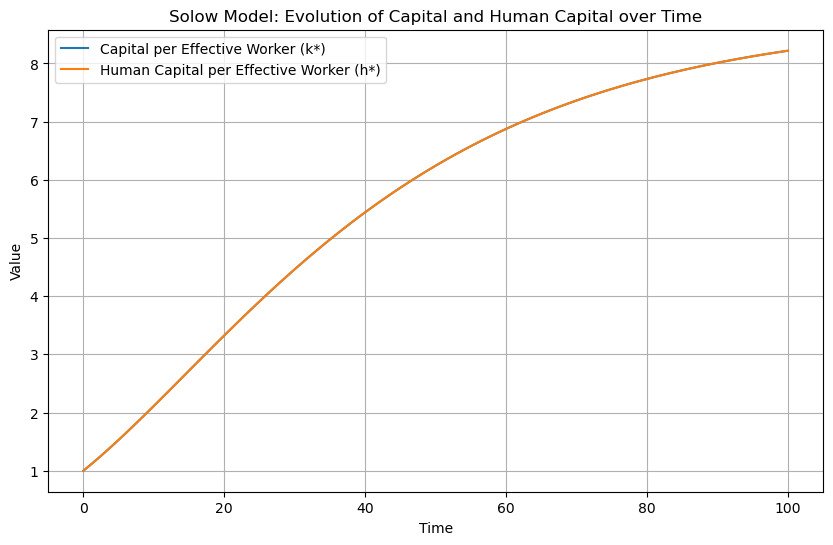

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Solow model transition equations
def solow_model_dynamics(k, h, s_K, s_H, alpha, phi, n, g, delta):
    k_next = (1 / ((1 + n) * (1 + g))) * (s_K * k**alpha * h**phi + (1 - delta) * k)
    h_next = (1 / ((1 + n) * (1 + g))) * (s_H * k**alpha * h**phi + (1 - delta) * h)
    return k_next, h_next

# Define parameter values
s_K = 0.2
s_H = 0.2
alpha = 0.33
phi = 0.33
n = 0.025
g = 0.02
delta = 0.05

# Initial conditions
k0 = 1.0  # Initial capital per effective worker
h0 = 1.0  # Initial human capital per effective worker

# Time points for integration (0 to 100 time units)
t = np.arange(0, 101)  # Time grid

# Simulate the dynamics of capital and human capital over time
k_sol = np.zeros(len(t))
h_sol = np.zeros(len(t))
k_sol[0] = k0
h_sol[0] = h0

for i in range(1, len(t)):
    k_sol[i], h_sol[i] = solow_model_dynamics(k_sol[i-1], h_sol[i-1], s_K, s_H, alpha, phi, n, g, delta)

# Plot the evolution of capital and human capital over time
plt.figure(figsize=(10, 6))
plt.plot(t, k_sol, label='Capital per Effective Worker (k*)')
plt.plot(t, h_sol, label='Human Capital per Effective Worker (h*)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Solow Model: Evolution of Capital and Human Capital over Time')
plt.legend()
plt.grid(True)
plt.show()




Fasediagram - both equal to H

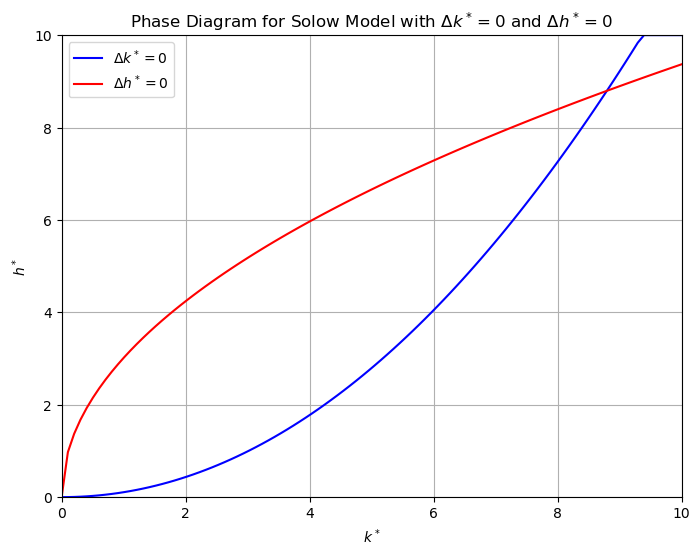

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define functions for steady-state h* when Δk* = 0 and Δh* = 0
def h_steady_state_delta_k_zero(k, s_K, n, g, delta, alpha, phi):
    return np.minimum(((n + g + delta + n*g) / s_K)**(1 / phi) * k**((1 - alpha) / phi), 10)

def h_steady_state_delta_h_zero(k, s_H, n, g, delta, alpha, phi):
    return np.minimum((s_H / (n + g + delta + n*g))**(1 / (1 - phi)) * k**(alpha / (1 - phi)), 10)

# Range of k* values (include 0 for starting point)
k_values = np.linspace(0, 10, 100)  # Adjust the range as needed

# Parameters
s_K = 0.2
s_H = 0.2
alpha = 0.33
phi = 0.33
n = 0.025
g = 0.02
delta = 0.05

# Calculate corresponding h* values for Δk* = 0 and Δh* = 0
h_delta_k_zero = h_steady_state_delta_k_zero(k_values, s_K, n, g, delta, alpha, phi)
h_delta_h_zero = h_steady_state_delta_h_zero(k_values, s_H, n, g, delta, alpha, phi)

# Plot the phase diagram
plt.figure(figsize=(8, 6))
plt.plot(k_values, h_delta_k_zero, label=r'$\Delta k^* = 0$', color='blue')
plt.plot(k_values, h_delta_h_zero, label=r'$\Delta h^* = 0$', color='red')
plt.xlabel(r'$k^*$')
plt.ylabel(r'$h^*$')
plt.ylim(0, 10)  # Set the y-axis limits to 0 and 10
plt.xlim(0, 10)  # Set the x-axis limits to 0 and 10
plt.title('Phase Diagram for Solow Model with $\Delta k^* = 0$ and $\Delta h^* = 0$')
plt.legend()
plt.grid(True)
plt.show()



# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Changes of parameter values - sensitivity analysis

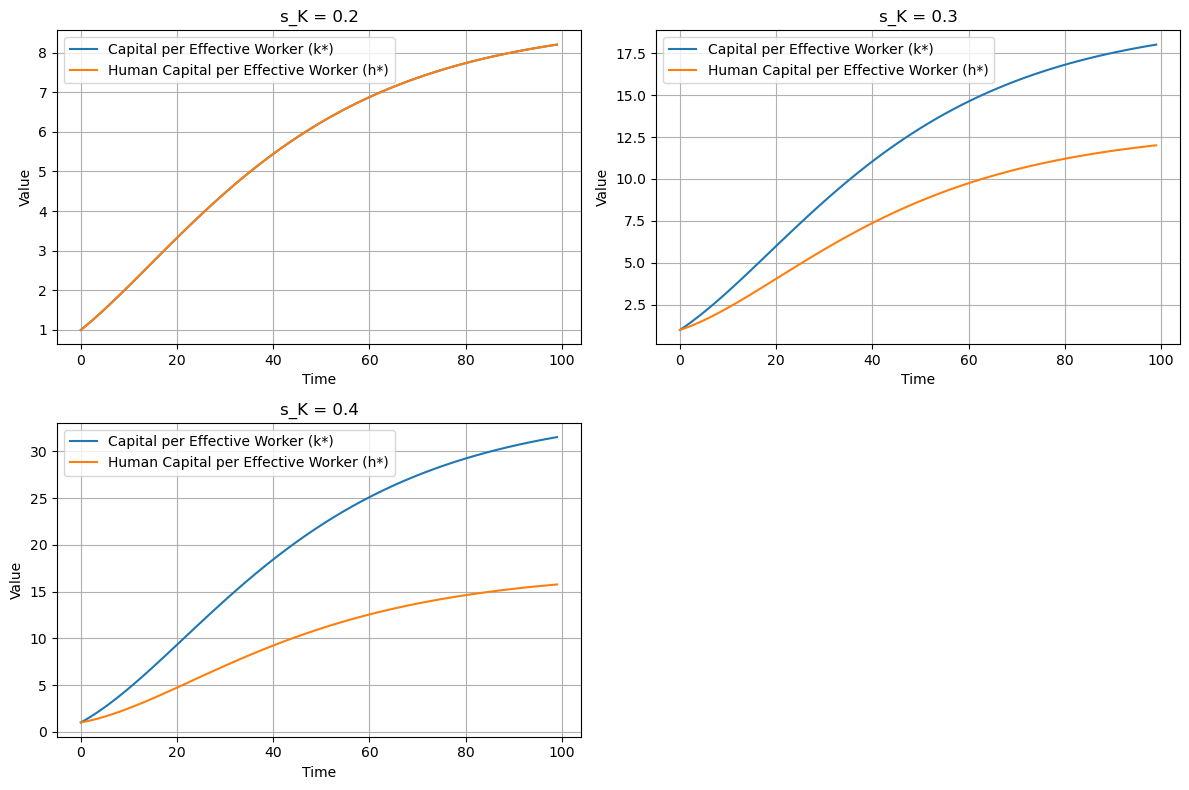

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Solow model transition equations
def solow_model_dynamics(k, h, s_K, s_H, alpha, phi, n, g, delta):
    k_next = (1 / ((1 + n) * (1 + g))) * (s_K * k**alpha * h**phi + (1 - delta) * k)
    h_next = (1 / ((1 + n) * (1 + g))) * (s_H * k**alpha * h**phi + (1 - delta) * h)
    return k_next, h_next

# Function to simulate Solow model dynamics over time
def simulate_solow_model(k0, h0, s_K, s_H, alpha, phi, n, g, delta, T):
    k_values = np.zeros(T)
    h_values = np.zeros(T)
    k_values[0] = k0
    h_values[0] = h0
    
    for t in range(1, T):
        k_next, h_next = solow_model_dynamics(k_values[t-1], h_values[t-1], s_K, s_H, alpha, phi, n, g, delta)
        k_values[t] = k_next
        h_values[t] = h_next
    
    return k_values, h_values

# Function to plot transitions over time
def plot_transitions_over_time(parameter_values, parameter_name, k0, h0, s_K, s_H, alpha, phi, n, g, delta, T):
    num_params = len(parameter_values)
    num_cols = 2
    num_rows = int(np.ceil(num_params / num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()
    
    for i, param_value in enumerate(parameter_values):
        if parameter_name == 's_K':
            s_K = param_value
        elif parameter_name == 's_H':
            s_H = param_value
        elif parameter_name == 'alpha':
            alpha = param_value
        elif parameter_name == 'phi':
            phi = param_value
        elif parameter_name == 'n':
            n = param_value
        elif parameter_name == 'g':
            g = param_value
        elif parameter_name == 'delta':
            delta = param_value
        
        k_values, h_values = simulate_solow_model(k0, h0, s_K, s_H, alpha, phi, n, g, delta, T)
        
        ax = axes[i]
        ax.plot(k_values, label='Capital per Effective Worker (k*)')
        ax.plot(h_values, label='Human Capital per Effective Worker (h*)')
        ax.set_title(f'{parameter_name} = {param_value}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)
    
    if num_params % 2 != 0:
        fig.delaxes(axes[num_params])  # Remove unused subplot
    
    plt.tight_layout()
    plt.show()

# Define parameter values for sensitivity analysis
parameter_values = [0.2, 0.3, 0.4]  # Example parameter values to vary
parameter_name = 's_K'  # Parameter to vary (e.g., 's_K', 's_H', 'alpha', 'phi', 'n', 'g', 'delta')
k0 = 1.0  # Initial capital per effective worker
h0 = 1.0  # Initial human capital per effective worker
T = 100  # Number of time steps

# Perform sensitivity analysis and plot transitions over time
plot_transitions_over_time(parameter_values, parameter_name, k0, h0, 0.2, 0.2, 0.33, 0.33, 0.025, 0.02, 0.05, T)




# Extension with technological growth

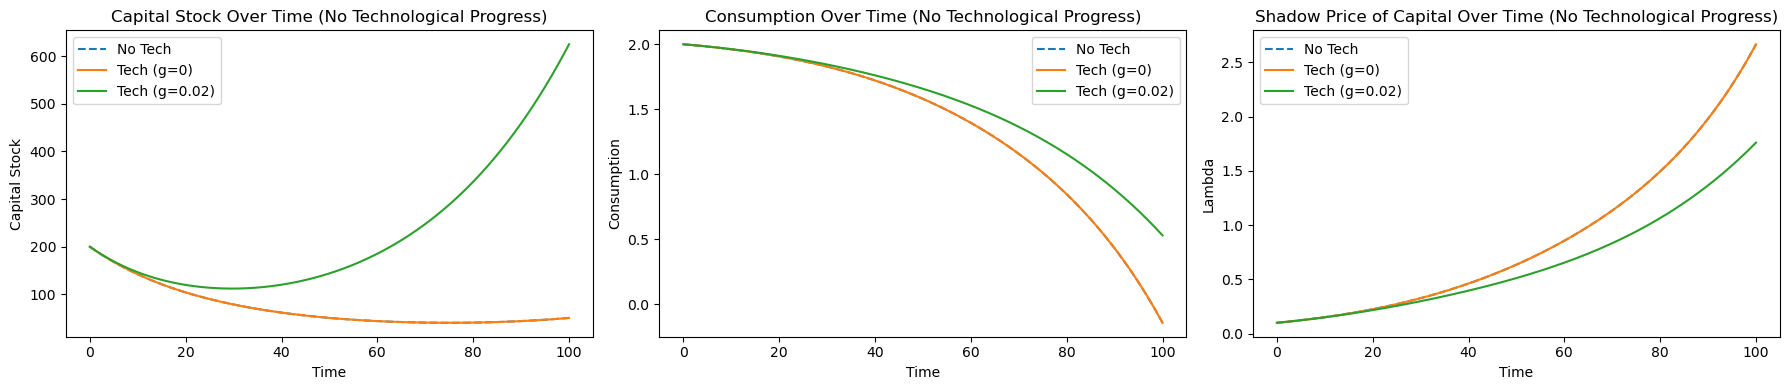

In [56]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
alpha = 0.3     # Output elasticity of capital
delta = 0.05    # Depreciation rate of capital
rho = 0.02      # Rate of time preference
theta = 2.0     # Coefficient of relative risk aversion
n = 0.01        # Labor growth rate
g_values = [0, 0.02]  # Technological growth rate for sensitivity analysis

# Production function
def production(K, L, A):
    return A * (K**alpha) * (L**(1-alpha))

# Utility function
def utility(c):
    return (c**(1 - theta) - 1) / (1 - theta)

# Differential equations from Hamiltonian with technological progress
def rck_system_with_tech(t, z, g):
    K, c, lam, A = z
    Y = production(K, 1, A)  # Assume constant labor force for simplicity
    dot_K = Y - c - delta * K
    dot_c = (lam / theta) * (alpha * Y / K - rho - delta)
    dot_lam = -lam * ((alpha * Y / K) - delta)
    dot_A = g * A
    return [dot_K, dot_c, dot_lam, dot_A]

# Solve RCK model without technological progress
def solve_rck_model(t_span, initial_conditions):
    return solve_ivp(rck_system_with_tech, t_span, initial_conditions, args=(0,), t_eval=t_eval, method='BDF')

# Solve RCK model with technological progress
def solve_rck_model_with_tech(t_span, initial_conditions, g):
    return solve_ivp(rck_system_with_tech, t_span, initial_conditions, args=(g,), t_eval=t_eval, method='BDF')

# Initial conditions
initial_conditions = [200, 2, 0.1, 1.0]  # Initial capital, consumption, lambda, and technological progress

# Time span for the simulation
t_span = (0, 100)
t_eval = np.linspace(*t_span, 300)

# Solve the RCK model without technological progress
solution_baseline = solve_rck_model(t_span, initial_conditions)

# Solve the RCK model with technological progress for different values of g
solutions_with_tech = []
for g_value in g_values:
    solution_with_tech = solve_rck_model_with_tech(t_span, initial_conditions, g_value)
    solutions_with_tech.append(solution_with_tech)

# Plotting results
plt.figure(figsize=(18, 4))

# Plot results from the baseline model without technological progress
plt.subplot(1, 3, 1)
plt.plot(solution_baseline.t, solution_baseline.y[0], label='No Tech', linestyle='--')
plt.title('Capital Stock Over Time (No Technological Progress)')
plt.xlabel('Time')
plt.ylabel('Capital Stock')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(solution_baseline.t, solution_baseline.y[1], label='No Tech', linestyle='--')
plt.title('Consumption Over Time (No Technological Progress)')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(solution_baseline.t, solution_baseline.y[2], label='No Tech', linestyle='--')
plt.title('Shadow Price of Capital Over Time (No Technological Progress)')
plt.xlabel('Time')
plt.ylabel('Lambda')
plt.legend()

# Plot results from the extended model with technological progress
for i, g_value in enumerate(g_values):
    plt.subplot(1, 3, 1)
    plt.plot(solutions_with_tech[i].t, solutions_with_tech[i].y[0], label=f'Tech (g={g_value})')
    plt.subplot(1, 3, 2)
    plt.plot(solutions_with_tech[i].t, solutions_with_tech[i].y[1], label=f'Tech (g={g_value})')
    plt.subplot(1, 3, 3)
    plt.plot(solutions_with_tech[i].t, solutions_with_tech[i].y[2], label=f'Tech (g={g_value})')

plt.subplot(1, 3, 1)
plt.legend()
plt.subplot(1, 3, 2)
plt.legend()
plt.subplot(1, 3, 3)
plt.legend()

plt.tight_layout()
plt.show()






# Conclusion

Add concise conclusion. 